# Clustering of HCP Unrelated 100 Subjects by ROI-Correlations in Resting State

## Import and Setup

In [1]:
from Main import get_timeseries_per_patient, timeseries_pearson_corr, get_centroids_per_region, create_network_graph_video, plot_in_orientation
from Import import get_parcellation_data, img_data_loader
from glob import glob
import re
import os
import cv2
import nibabel as nib
import nilearn.image as nimg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

In [2]:
# import all timeseries
files = glob("D:/HCP/Unrelated 100/Patients/timeseries/*")
all_timeseries = [np.load(file) for file in files]
len(all_timeseries)

100

In [3]:
# import all centroids
files = glob("./Data/centroids/*")
all_centroids = np.concatenate([np.load(file) for file in files], axis=0)
all_centroids

array([[64.46511628, 59.51928531, 60.82019285],
       [24.44957113, 58.22508134, 61.40490979],
       [54.38649625, 79.74492915, 56.47707697],
       [34.1984714 , 77.95512821, 57.25221893],
       [53.41225337, 85.95950156, 28.64070613],
       [35.9107322 , 86.30892678, 28.25275827],
       [61.87949825, 78.7446021 , 53.06539173],
       [26.30407524, 78.87539185, 52.40713166],
       [60.44256757, 87.57094595, 30.50675676],
       [28.55270936, 88.63743842, 29.92906404],
       [69.39788054, 68.74566474, 44.90077071],
       [20.03645461, 69.83774124, 46.09792709],
       [67.94503756, 77.33333333, 42.29141953],
       [19.9693166 , 77.45095305, 42.40864714],
       [63.12011834, 77.74615385, 29.2704142 ],
       [24.54481547, 78.4973638 , 29.37082601],
       [68.7030303 , 58.11212121, 42.31919192],
       [18.80916604, 59.23140496, 42.6649136 ],
       [47.84536563, 64.77503493, 66.03213787],
       [40.87684521, 62.45339519, 66.25643189],
       [49.13214286, 69.93214286, 29.657

In [4]:
# load atlas data
region_maps, region_maps_data, masked_aal, regions, region_labels = get_parcellation_data(fetched=True)

In [5]:
region_labels

array([['FAG', 'Precentral_L', '2001'],
       ['FAD', 'Precentral_R', '2002'],
       ['F1G', 'Frontal_Sup_L', '2101'],
       ['F1D', 'Frontal_Sup_R', '2102'],
       ['F1OG', 'Frontal_Sup_Orb_L', '2111'],
       ['F1OD', 'Frontal_Sup_Orb_R', '2112'],
       ['F2G', 'Frontal_Mid_L', '2201'],
       ['F2D', 'Frontal_Mid_R', '2202'],
       ['F2OG', 'Frontal_Mid_Orb_L', '2211'],
       ['F2OD', 'Frontal_Mid_Orb_R', '2212'],
       ['F3OPG', 'Frontal_Inf_Oper_L', '2301'],
       ['F3OPD', 'Frontal_Inf_Oper_R', '2302'],
       ['F3TG', 'Frontal_Inf_Tri_L', '2311'],
       ['F3TD', 'Frontal_Inf_Tri_R', '2312'],
       ['F3OG', 'Frontal_Inf_Orb_L', '2321'],
       ['F3OD', 'Frontal_Inf_Orb_R', '2322'],
       ['ORG', 'Rolandic_Oper_L', '2331'],
       ['ORD', 'Rolandic_Oper_R', '2332'],
       ['SMAG', 'Supp_Motor_Area_L', '2401'],
       ['SMAD', 'Supp_Motor_Area_R', '2402'],
       ['COBG', 'Olfactory_L', '2501'],
       ['COBD', 'Olfactory_R', '2502'],
       ['FMG', 'Frontal_Sup_Medial

In [7]:
# setup
patients = ["100307", "100408", "101107", "101309", "101915", "103111", "103414", "103818", "105014", "105115", "106016", "108828", "110411", "111312", "111716", "113619", "113922", "114419", "115320", "116524", "117122", "118528", "118730", "118932", "120111", "122317", "122620", "123117", "123925", "124422", "125525", "126325", "127630", "127933", "128127", "128632", "129028", "130013", "130316", "131217", "131722", "133019", "133928", "135225", "135932", "136833", "138534", "139637", "140925", "144832", "146432", "147737", "148335", "148840", "149337", "149539", "149741", "151223", "151526", "151627", "153025", "154734", "156637", "159340", "160123", "161731", "162733", "163129", "176542", "178950", "188347", "189450", "190031", "192540", "196750", "198451", "199655", "201111", "208226", "211417", "211720", "212318", "214423", "221319", "239944", "245333", "280739", "298051", "366446", "397760", "414229", "499566", "654754", "672756", "751348", "756055", "792564", "856766", "857263", "899885"]
patient_id = "100307"
patient_num = patients.index(patient_id)

timestamp = 70

region_to_plot = "F3TG"
index = np.where(region_labels == region_to_plot)
region_id = int(region_labels[index[0],2])

sagittal_slice = 70
coronal_slice = 70
transversal_slice = 45

correlation_threshold = 0.75

In [8]:
# load Average T1w Image
path_T1w = "./Data/S1200_AverageT1w_restore.nii.gz"
img_T1w, img_data_T1w = img_data_loader(path_T1w)

In [9]:
# load specific fMRI Image
path_fMRI = os.path.join("D:/HCP/Unrelated 100/Patients", patient_id, "MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_hp2000_clean.nii.gz")
img_fMRI = nib.load(path_fMRI)

## Visualize Brain Regions

In [10]:
# resample Images to region labels
resampled_img_data_T1w = nimg.resample_to_img(img_T1w, region_maps, interpolation='nearest').get_fdata()
resampled_img_fMRI = nimg.resample_to_img(img_fMRI, region_maps, interpolation='nearest') if img_fMRI.shape[0:3] != region_maps.shape else img_fMRI
resampled_img_data_fMRI = resampled_img_fMRI.dataobj[:, :, :, timestamp]
# mask all but the chosen region
masked_aal = np.ma.masked_where(masked_aal != region_id, masked_aal)
# mask so that values of 0 are not shown
resampled_img_data_fMRI_masked = np.ma.masked_where(resampled_img_data_fMRI == 0, resampled_img_data_fMRI)

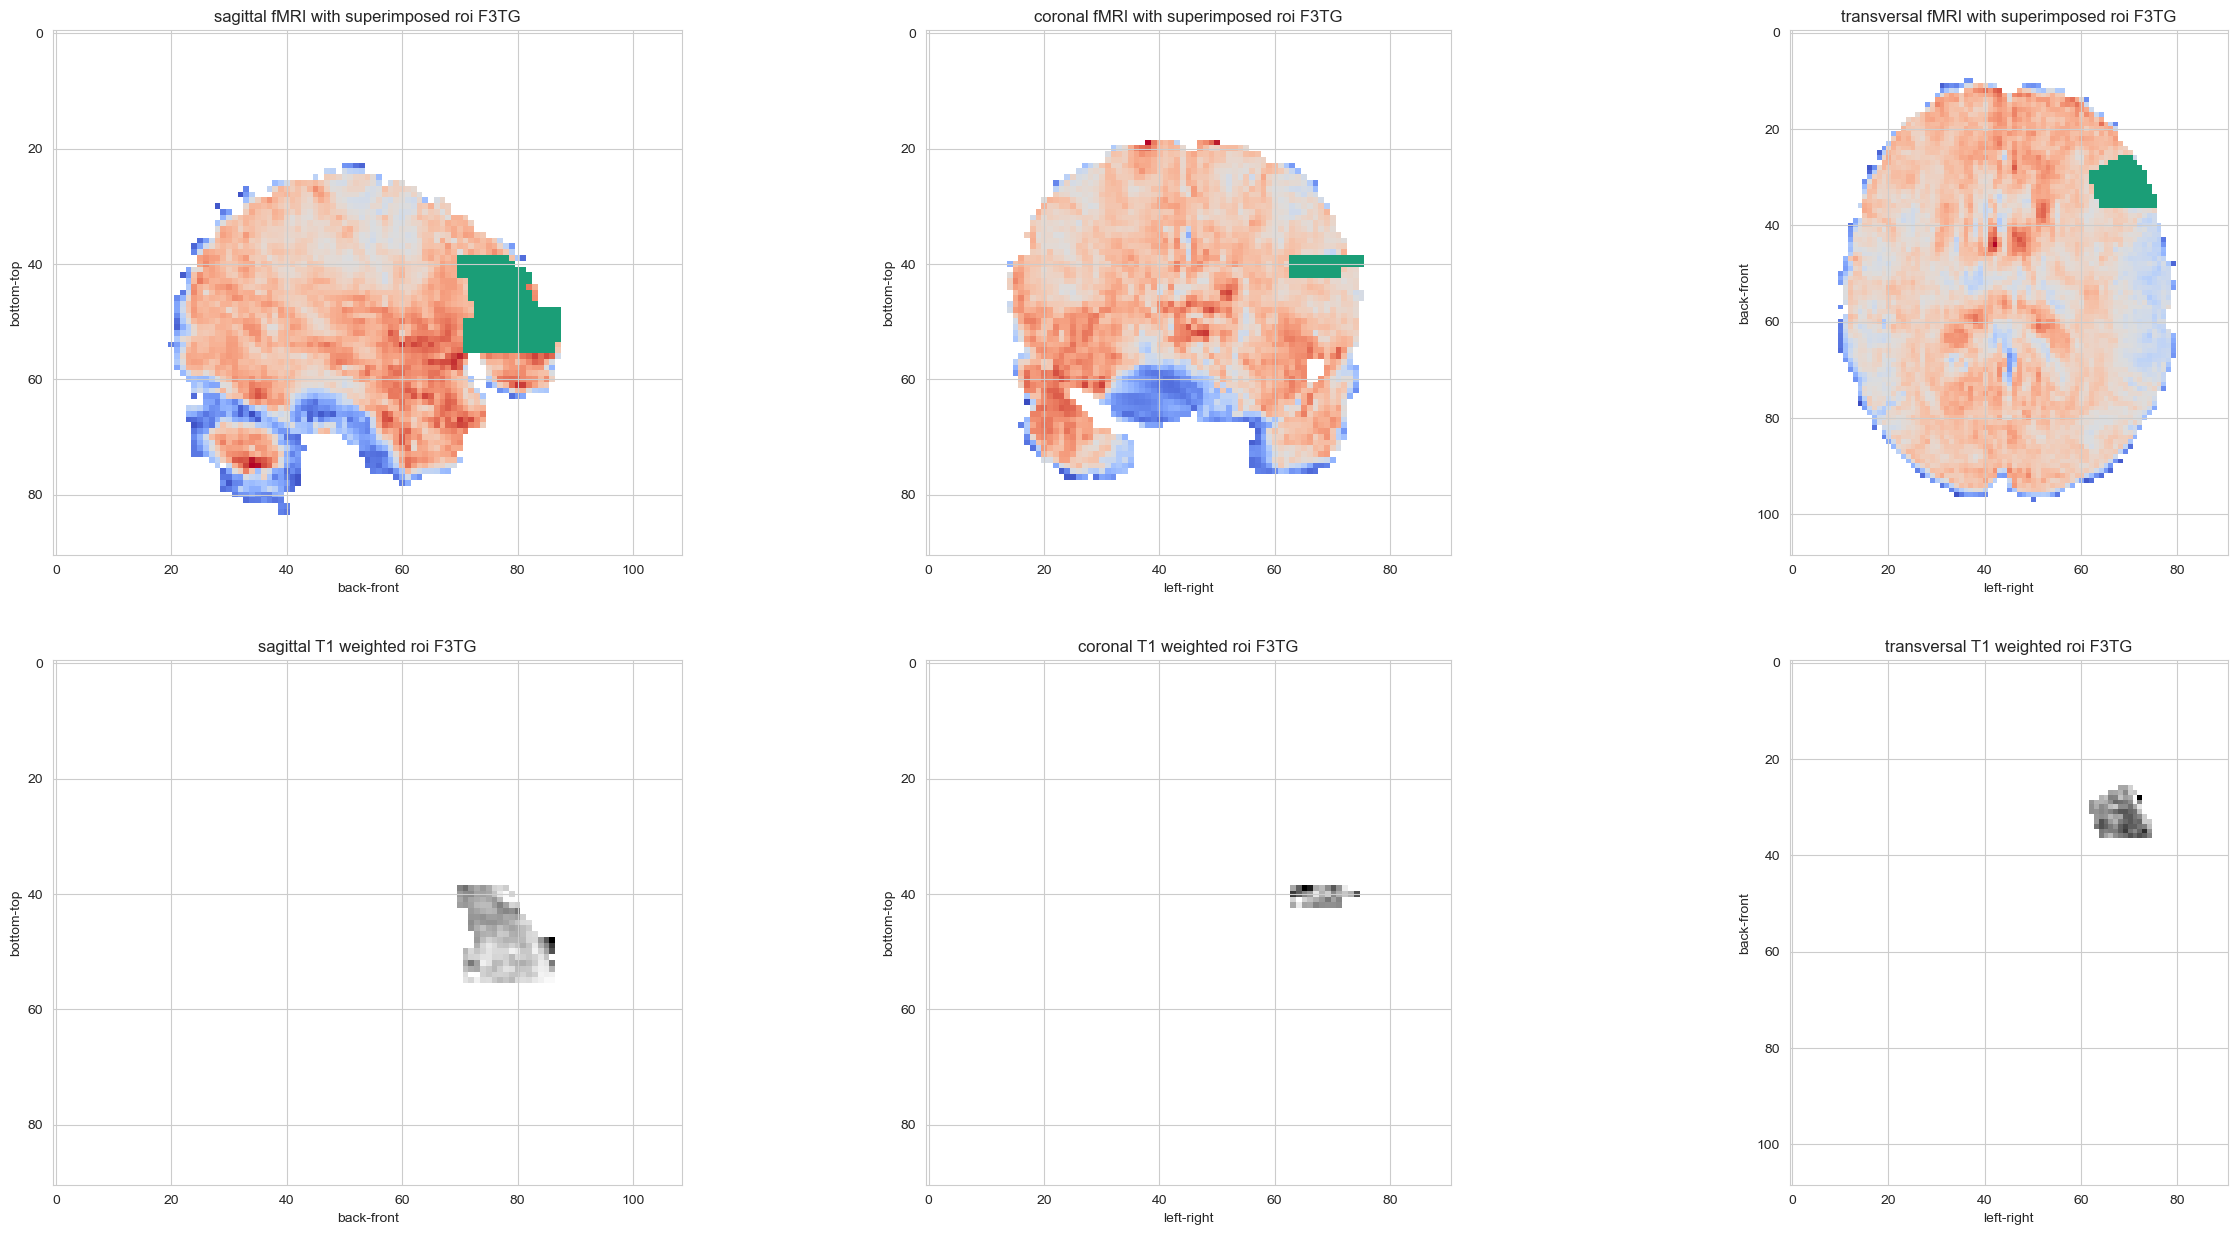

In [11]:
fig, axs = plt.subplots(2,3, figsize=(30,15))
orientations = ['sagittal', 'coronal', 'transversal']
slices = [sagittal_slice, coronal_slice, transversal_slice]
for orientation_num, orientation in enumerate(orientations):
    # plot fMRI-image with roi
    plot_in_orientation(resampled_img_data_fMRI_masked, orientation, slices[orientation_num], ax=axs[0, orientation_num], cmap="coolwarm")
    plot_in_orientation(masked_aal, orientation, slices[orientation_num], cmap="Dark2", ax=axs[0, orientation_num])

    # plot region
    resampled_img_data_fMRI_oneRegionOnly = resampled_img_data_fMRI * (region_maps_data == region_id)
    masked_region = np.ma.masked_where(resampled_img_data_fMRI_oneRegionOnly == 0,
                                   resampled_img_data_fMRI_oneRegionOnly)
    plot_in_orientation(masked_region, orientation, slices[orientation_num], ax=axs[1, orientation_num])

    # set titles
    axs[0, orientation_num].set_title(f"{orientation} fMRI with superimposed roi {region_to_plot}")
    axs[1, orientation_num].set_title(f"{orientation} T1 weighted roi {region_to_plot}")

axs[0, 0].set_xlabel("back-front")
axs[1, 0].set_xlabel("back-front")
axs[0, 1].set_xlabel("left-right")
axs[1, 1].set_xlabel("left-right")
axs[0, 2].set_xlabel("left-right")
axs[1, 2].set_xlabel("left-right")
axs[0, 0].set_ylabel("bottom-top")
axs[1, 0].set_ylabel("bottom-top")
axs[0, 1].set_ylabel("bottom-top")
axs[1, 1].set_ylabel("bottom-top")
axs[0, 2].set_ylabel("back-front")
axs[1, 2].set_ylabel("back-front");

## Visualize Timeseries

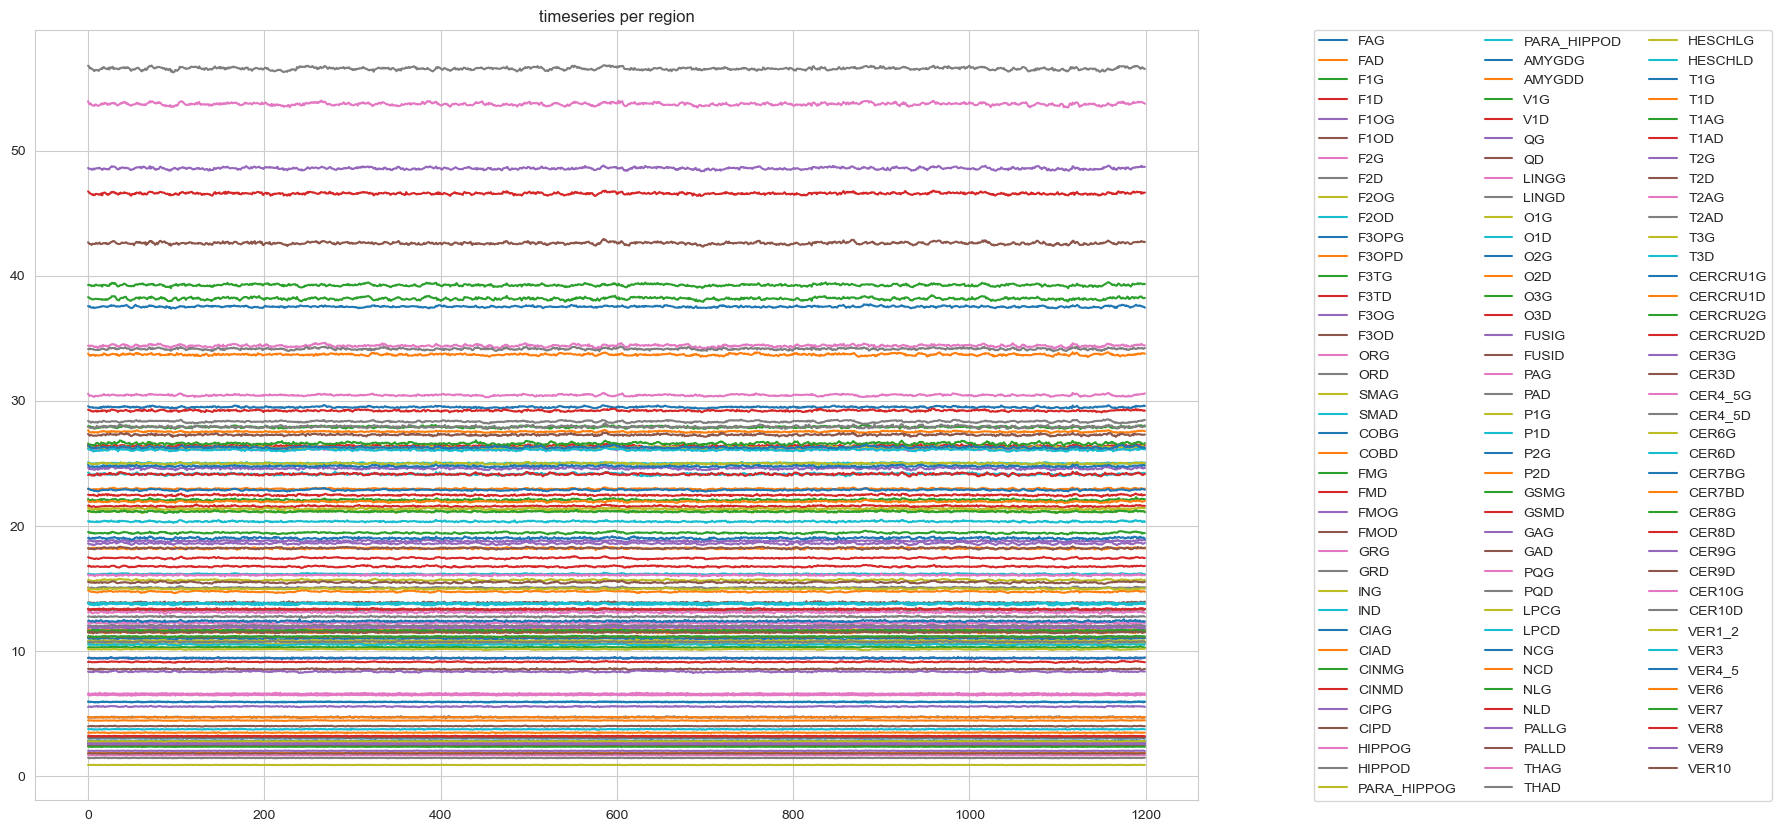

In [12]:
# plot the patients timeseries
timeseries = all_timeseries[patient_num]
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(timeseries[:, :])
ax.set_title("timeseries per region")
ax.legend(region_labels[:, 0], bbox_to_anchor=(1.5, 0.5), loc="right", ncols=3);

## Compute Pearson`s r

In [13]:
# compute correlation between regions in sliding window
correlation_matrices_per_patient = timeseries_pearson_corr(timeseries, step_width=5, overlap_percentage=0.2)

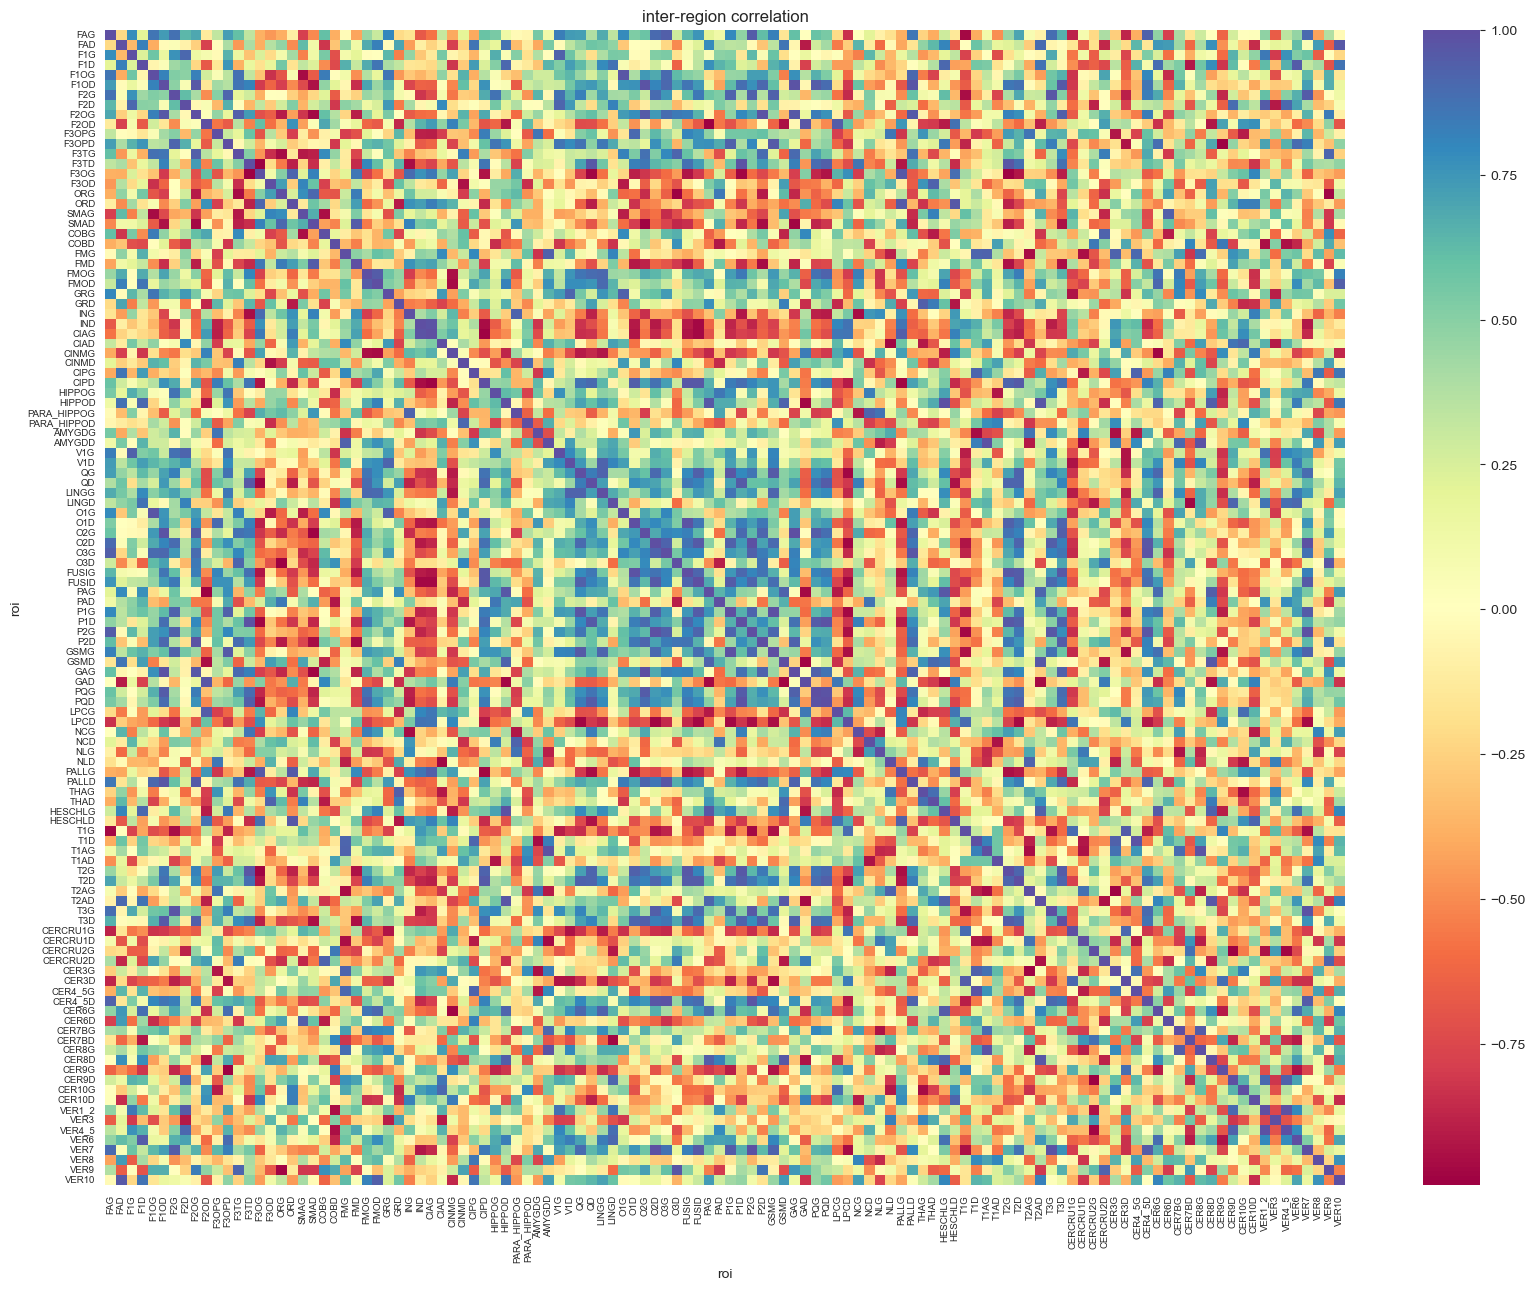

In [14]:
# plot correlation matrix
axis_labels = region_labels[:, 0]
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(correlation_matrices_per_patient[timestamp], ax=ax, cmap='Spectral')
ax.set_title("inter-region correlation")
ax.set_xlabel("roi")
ax.set_ylabel("roi")
ax.set_xticks(np.arange(len(regions))+0.5, axis_labels, fontsize="x-small")
ax.set_yticks(np.arange(len(regions))+0.5, axis_labels, fontsize="x-small");

## Compute and visualize Network Graph

In [15]:
# set diagonal to 0 (no correlation of region with itself), compute absolute value to have only positive correlations and set all values <= threshold to 0
for k in np.arange(len(correlation_matrices_per_patient)):
    for l in np.arange(len(regions)):
        correlation_matrices_per_patient[k][l,l] = 0
correlation_matrices_per_patient_abs = np.abs(correlation_matrices_per_patient)
correlation_matrices_per_patient_abs_thresh = correlation_matrices_per_patient_abs * (correlation_matrices_per_patient_abs>correlation_threshold)

In [16]:
# compute network graph
graph = nx.from_numpy_array(correlation_matrices_per_patient_abs_thresh[timestamp])

In [18]:
# compute weights of connections based on correlation
all_weights = []
for (node1, node2, data) in graph.edges(data=True):
    all_weights.append(correlation_matrices_per_patient_abs_thresh[timestamp][node1, node2])

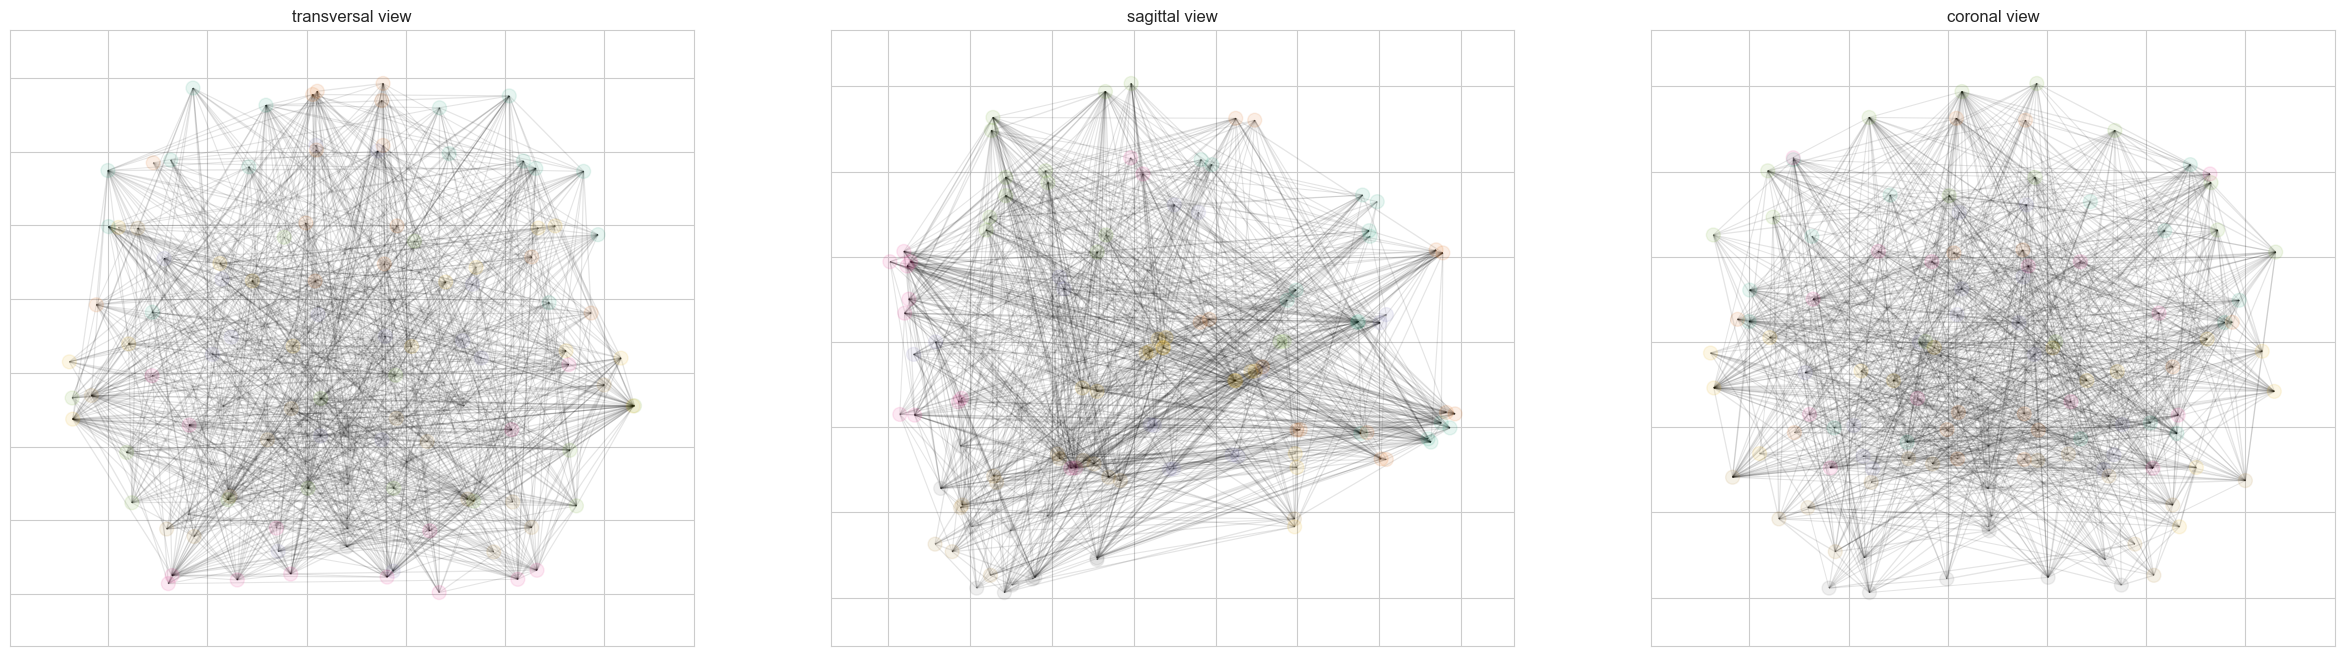

In [19]:
# plot 2D network graph with custom positions
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
views = [all_centroids[:, 0:2], all_centroids[:, 1:3], all_centroids[:, 0:3:2]]
titles = ["transversal view", "sagittal view", "coronal view"]
for ax_num, ax in enumerate(axs):
    pos = views[ax_num]
    nx.draw_networkx(graph, pos=pos, alpha=0.1, node_size=100, node_color=range(116), width=all_weights, with_labels=False, ax=ax, cmap="Dark2", labels=dict(zip(range(len(regions)), region_labels[:, 0])))
    ax.set_title(titles[ax_num])

In [20]:
# image transposing
coronal = np.transpose(resampled_img_data_T1w, [0, 2, 1])
coronal = np.rot90(coronal, 3)
coronal_image = coronal[:, :, coronal_slice]
sagittal = np.transpose(resampled_img_data_T1w, [1, 2, 0])
sagittal = np.rot90(sagittal, 0)
sagittal_image = sagittal[:, :, sagittal_slice]
transversal = np.transpose(resampled_img_data_T1w, [0, 1, 2])
transversal = np.rot90(transversal, 3)
transversal_image = transversal[:, :, transversal_slice]

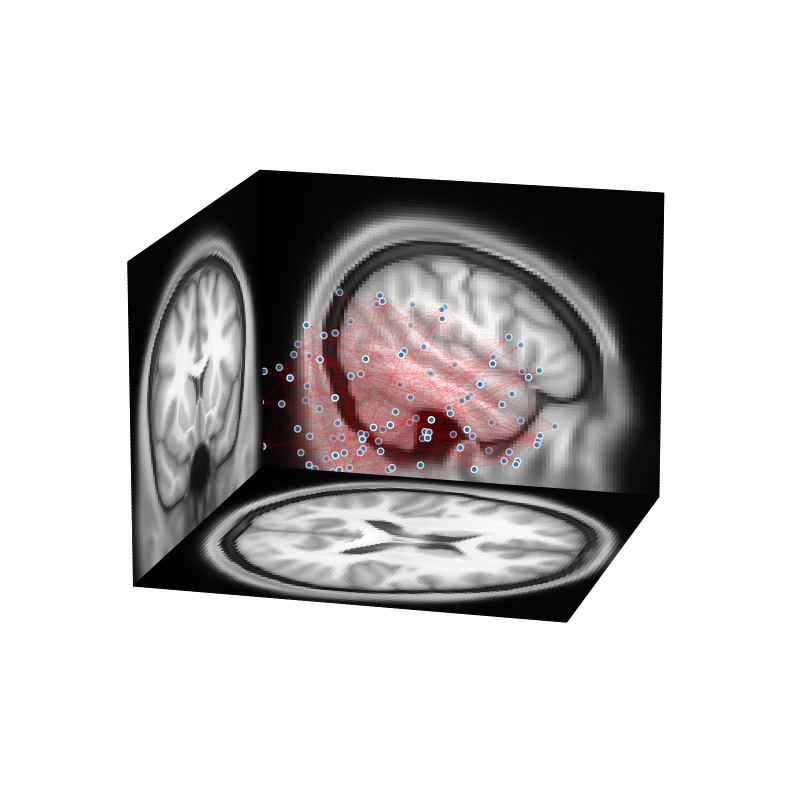

In [21]:
pos = all_centroids
node_pos = pos
edge_pos = np.array([(pos[u], pos[v]) for u, v in graph.edges])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x1, y1 = np.meshgrid(np.linspace(0,transversal.shape[1],transversal.shape[1]), np.linspace(0,transversal.shape[0],transversal.shape[0]))
z1 = np.zeros(x1.shape)
ax.plot_surface(x1, y1, z1, rstride=1, cstride=1, facecolors=plt.cm.gray(transversal_image/transversal_image.max()), shade=False)
x2, z2 = np.meshgrid(np.linspace(0,coronal.shape[0],coronal.shape[0]), np.linspace(0,coronal.shape[1],coronal.shape[1]))
y2 = np.zeros(x2.shape)
ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, facecolors=plt.cm.gray(coronal_image/coronal_image.max()), shade=False)
z3, y3 = np.meshgrid(np.linspace(0,sagittal.shape[1],sagittal.shape[1]), np.linspace(0,sagittal.shape[0],sagittal.shape[0]))
x3 = np.zeros(z3.shape)
ax.plot_surface(x3, y3, z3, rstride=1, cstride=1, facecolors=plt.cm.gray(sagittal_image/sagittal_image.max()), shade=False)
ax.scatter3D(*node_pos.T, s=20, ec="w")
for edge_num in np.arange(edge_pos.shape[0]):
    ax.plot3D(xs=(edge_pos[edge_num, 0, 0], edge_pos[edge_num, 1, 0]), ys=(edge_pos[edge_num, 0, 1], edge_pos[edge_num, 1, 1]), zs=(edge_pos[edge_num, 0, 2], edge_pos[edge_num, 1, 2]), color="red", linewidth=all_weights[edge_num]*0.5, alpha=0.1)
ax.view_init(15, 15)
ax.set_axis_off()

In [10]:
# create video
# code adapted based on code by BoboDarph under https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python and code under https://note.nkmk.me/en/python-sort-num-str/

image_folder = './Data/video'
video_name = './Data/video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda s: int(re.search(r'\d+', s).group()))
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'h264')

video = cv2.VideoWriter(video_name, fourcc, 12, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()